# Analyzing The 'Sonic Brutality' of Songs, Using The Spotify API

A walkthrough, exploring the Spotify API / spotipy wrapper. Calculating a 'Sonic Brutality Index' for all Cannibal Corpse songs.

**Resources**

- [Spotify Web API reference](https://developer.spotify.com/documentation/web-api/reference/)
- [Spotipy docs (Python Wrapper)](https://spotipy.readthedocs.io/en/latest/)


**Data Output:**

- `data/interim/audio_data.csv`: DataFrame of all CC tracks with "Sonic Brutality Index"

**Changes**

- 2019-01-18: Start project
- 2020-01-25: Complete audio analysis
- 2020-02-08: Refactor some parts


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries,-instantiate-Spotipy-client" data-toc-modified-id="Import-libraries,-instantiate-Spotipy-client-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries, instantiate Spotipy client</a></span></li><li><span><a href="#Request-data-from-the-Spotify-API" data-toc-modified-id="Request-data-from-the-Spotify-API-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Request data from the Spotify API</a></span><ul class="toc-item"><li><span><a href="#Artist" data-toc-modified-id="Artist-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Artist</a></span></li><li><span><a href="#Trackslist" data-toc-modified-id="Trackslist-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Trackslist</a></span></li><li><span><a href="#Audio-Features" data-toc-modified-id="Audio-Features-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Audio Features</a></span></li></ul></li><li><span><a href="#Analyse-Songs" data-toc-modified-id="Analyse-Songs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analyse Songs</a></span><ul class="toc-item"><li><span><a href="#Prepare-dataframe" data-toc-modified-id="Prepare-dataframe-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare dataframe</a></span></li><li><span><a href='#Calculate-"Sonic-Brutality-Index"' data-toc-modified-id='Calculate-"Sonic-Brutality-Index"-3.2'><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Calculate "Sonic Brutality Index"</a></span></li></ul></li><li><span><a href="#Appendix:-Compare-Sonic-Brutality-of-Cannibal-Corpse-and-Cannabis-Corpse" data-toc-modified-id="Appendix:-Compare-Sonic-Brutality-of-Cannibal-Corpse-and-Cannabis-Corpse-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Appendix: Compare Sonic Brutality of Cannibal Corpse and Cannabis Corpse</a></span></li></ul></div>

---

## Import libraries, instantiate Spotipy client

In [1]:
# Import libraries

from pprint import pprint
import json
import numpy as np
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import credentials  # file where API credentials for spotify / genius are stored


# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('raph-base')
import seaborn as sns 

In [2]:
# Import credentials and instantiate client with authorization

SPOTIPY_CLIENT_ID = credentials.client_id
SPOTIPY_CLIENT_SECRET = credentials.client_secret

client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, 
                                                      client_secret=SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## Request data from the Spotify API

### Artist

In [3]:
# Get Artist URI

name = "Cannibal Corpse"

def get_artist_uri(name):
    results = sp.search(q='artist:' + name, type='artist')
    items = results['artists']['items']
    artist_uri = items[0]['uri'] 
    return artist_uri

In [4]:
artist_uri = get_artist_uri(name)
pprint(artist_uri)

'spotify:artist:0yLwGBQiBqhXOvmTfH2A7n'


### Trackslist

The easiest way to query for tracks is as follows:

```python
results = sp.search(q=artist, limit=50, type='track')
for i, t in enumerate(results['tracks']['items']):
    print(' ', i, t['name'])
```

But as the upper limit per request is 50 songs, and CC have released many more than that, so I work around by requesting a list of all their albums, clean it a bit, and then combine all the tracks in one big tracklist.

In [5]:
# Get Artist albums (dict)
# Note: setting title as key catches some duplicates

def get_artist_albums(artist_uri):
    albums = {}
    results = sp.artist_albums(artist_uri, album_type='album', limit=25)
    for i, item in enumerate(results['items']):
        albums[item['name'].title()] = item['uri']
    return albums

In [6]:
artist_albums = get_artist_albums(artist_uri)
pprint(artist_albums)

{'A Skeletal Domain': 'spotify:album:3Am2ExqPJjrw51AU2HRJSF',
 'Bloodthirst': 'spotify:album:4AObEzsEDC6WOAlJCRL9Pa',
 'Butchered At Birth': 'spotify:album:0JuQm6O4YBzXb1M3Ln8eWz',
 'Eaten Back To Life': 'spotify:album:7uB1DKYuNh0sGkvJ42K26f',
 'Evisceration Plague': 'spotify:album:03jcqKD4ZthRxviJQIPCYf',
 'Gallery Of Suicide': 'spotify:album:3fEMj3Nr6Dpu7rFvgi1rg9',
 'Global Evisceration': 'spotify:album:4OZFh833qdZrK6DyelNAwS',
 'Gore Obsessed': 'spotify:album:4QnPTzLdkNwnvXxjKZ3AgF',
 'Kill': 'spotify:album:6ilBwRWtEedIQu4Q0YyIux',
 'Live Cannibalism': 'spotify:album:4eqhYFJAudlSc42bj0JKa9',
 'Red Before Black': 'spotify:album:2Ecgc9nNxJpXd3gboFPbvz',
 'The Bleeding': 'spotify:album:1FOBUa0z9RhKPH0frnWMRa',
 'The Bleeding - Reissue': 'spotify:album:18byNZK0g3PGvvebCYQpwm',
 'The Wretched Spawn': 'spotify:album:46QEzkj6cg7FxmIHL7zTjR',
 'Tomb Of The Mutilated': 'spotify:album:2yPAe2RJCfrfV97c8FKKjb',
 'Torture': 'spotify:album:7AaZ6zhZXDKilXqsJ52g8b',
 'Torturing And Eviscerating': 

In [7]:
# Manually clean some entries, we want original albums only and no live performances
albums_to_delete = ['レッド・ビフォー・ブラック', 
                     'Vile (Expanded Edition)', 
                     'The Bleeding - Reissue',
                     'Live Cannibalism',
                     'Torturing And Eviscerating',
                     'Global Evisceration'
                   ]
def get_clean_album_uri_list(artist_albums, albums_to_delete=albums_to_delete):
    if albums_to_delete is not None:
        for key in albums_to_delete:
            artist_albums.pop(key)  
    artist_albums_uri = [uri for uri in artist_albums.values()]
    return artist_albums_uri

In [8]:
artist_albums_uri = get_clean_album_uri_list(artist_albums, albums_to_delete)
print(artist_albums_uri)

['spotify:album:2Ecgc9nNxJpXd3gboFPbvz', 'spotify:album:3Am2ExqPJjrw51AU2HRJSF', 'spotify:album:7AaZ6zhZXDKilXqsJ52g8b', 'spotify:album:03jcqKD4ZthRxviJQIPCYf', 'spotify:album:6ilBwRWtEedIQu4Q0YyIux', 'spotify:album:46QEzkj6cg7FxmIHL7zTjR', 'spotify:album:4QnPTzLdkNwnvXxjKZ3AgF', 'spotify:album:4AObEzsEDC6WOAlJCRL9Pa', 'spotify:album:3fEMj3Nr6Dpu7rFvgi1rg9', 'spotify:album:6jgJTpnqytev0AHfkpFKFb', 'spotify:album:1FOBUa0z9RhKPH0frnWMRa', 'spotify:album:2yPAe2RJCfrfV97c8FKKjb', 'spotify:album:0JuQm6O4YBzXb1M3Ln8eWz', 'spotify:album:7uB1DKYuNh0sGkvJ42K26f']


In [9]:
# Get the full tracklist
def get_full_tracklist_dict(artist_albums_uri):
    tracklist = {}
    for album_uri in artist_albums_uri:
        album = sp.album(album_uri)
        for track in album['tracks']['items']:
            tracklist[track['name'].title()] = track['uri']
    return tracklist

In [10]:
full_tracklist = get_full_tracklist_dict(artist_albums_uri)
print(list(full_tracklist.items())[0])
print("Total tracks:", len(full_tracklist))

('Only One Will Die', 'spotify:track:2VDXsHWJ9L0gFm3bL4Ic1Q')
Total tracks: 164


### Audio Features

We use the audio features provided by spotify ([see here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)) to determine the sonic brutality of a track. We actually only need `Energy`and `Valence` for that, but in addition let's also have a look at the `Dancability`of Cannibal Corpse. Just for fun.

> Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
    
> Valence is a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). 
    
> Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.

In [11]:
def get_audio_features_dict(full_tracklist):
    audio_features_dict = {}
    for uri in list(full_tracklist.values()):
        features = sp.audio_features(uri)
        audio_features_dict[uri] = {'energy': features[0]['energy'],
                                    'valence': features[0]['valence'],
                                    'danceability': features[0]['danceability'],
                                   }
    return audio_features_dict

In [12]:
audio_features_dict = get_audio_features_dict(full_tracklist)
pprint(list(audio_features_dict.items())[:2])

retrying ...6secs
[('spotify:track:2VDXsHWJ9L0gFm3bL4Ic1Q',
  {'danceability': 0.24, 'energy': 0.981, 'valence': 0.217}),
 ('spotify:track:1M3QUZOIhq8LNkMJ8axsLM',
  {'danceability': 0.368, 'energy': 0.994, 'valence': 0.129})]


## Analyse Songs

### Prepare dataframe

Getting the songs and features in separate dicts was ok for exploring the Spotify API and Spotipy wrapper, but for our the actual Analyis I prefer to combine everything in a dataframe.

In [13]:
temp_df1 = pd.DataFrame(full_tracklist.items(), columns = ['title', 'uri'])
temp_df2 = pd.DataFrame(audio_features_dict.items(), columns = ['uri', 'features'])
assert len(temp_df1) == len(temp_df2)
song_data = pd.merge(temp_df1, temp_df2, on=['uri'])
display(song_data.head(2))

,title,uri,features
0,Only One Will Die,spotify:track:2VDXsHWJ9L0gFm3bL4Ic1Q,"{'energy': 0.981, 'valence': 0.217, 'danceabil..."
1,Red Before Black,spotify:track:1M3QUZOIhq8LNkMJ8axsLM,"{'energy': 0.994, 'valence': 0.129, 'danceabil..."


In [14]:
song_data['energy'] = song_data['uri'].apply(lambda x: audio_features_dict[x]['energy'])
song_data['valence'] = song_data['uri'].apply(lambda x: audio_features_dict[x]['valence'])
song_data['danceability'] = song_data['uri'].apply(lambda x: audio_features_dict[x]['danceability'])
song_data.drop('features', axis=1, inplace=True)

In [15]:
display(song_data.head(2))

,title,uri,energy,valence,danceability
0,Only One Will Die,spotify:track:2VDXsHWJ9L0gFm3bL4Ic1Q,0.981,0.217,0.240
1,Red Before Black,spotify:track:1M3QUZOIhq8LNkMJ8axsLM,0.994,0.129,0.368


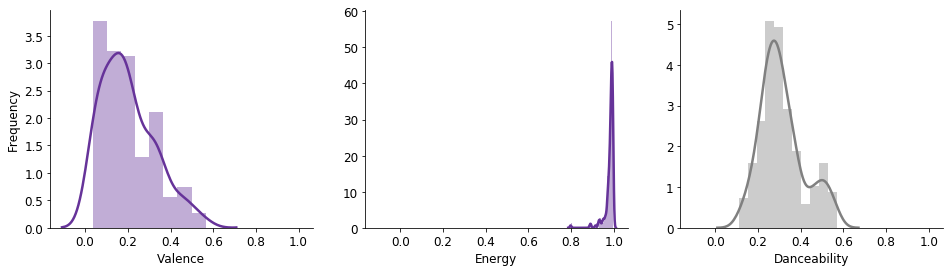

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(16,4))
sns.distplot(song_data['valence'], ax=axes[0])
sns.distplot(song_data['energy'], ax=axes[1])
sns.distplot(song_data['danceability'],color="grey", ax=axes[2])

axes[0].set_xlabel('Valence', fontsize='large')
axes[1].set_xlabel('Energy', fontsize='large')
axes[2].set_xlabel('Danceability', fontsize='large')
axes[0].set_ylabel('Frequency', fontsize='large');

In [17]:
# Check for outlier with energy value of approx. 0.8 only
# And get link to a 30 sek sample

low_energy_uri = song_data['uri'].loc[song_data['energy'] == song_data['energy'].min()].values[0]
results = sp.track(low_energy_uri)
print('track       : ' + results['name'])
print('from ablbum : ' + results['album']['name'])
print('audio       : ' + results['preview_url'])
print('cover art   : ' + results['album']['images'][0]['url'])


track       : From Skin to Liquid
from ablbum : Gallery of Suicide
audio       : https://p.scdn.co/mp3-preview/b365c4e05003bd21bc5387aa0cc123a319a9a061?cid=4a73009f43b84a8f88e6a857c198ad8f
cover art   : https://i.scdn.co/image/ab67616d0000b27330ad46095a88e6fad36ecded


### Calculate "Sonic Brutality Index"

Using both `energy` and `valence`, we can create an equation for the “Sonic Brutality Index” by calculating the arithmetic mean of `energy` and `1 - valence` (subtracting valence from 1 so that a higher value means it’s more “negative”). This way, the most brutal songs will be those that are both high in energy and low in valence, while equally weighting both.

$$\\Sonic Brutality Index = \frac{(1 - valence) + energy}{2}$$

In [18]:
def calc_sbi(valence, energy):
    sbi = ((1 - valence) + energy) / 2
    return sbi
    
song_data['sbi'] = song_data.apply(lambda x: calc_sbi(x['valence'], x['energy']), axis=1)
display(song_data.head(2))

,title,uri,energy,valence,danceability,sbi
0,Only One Will Die,spotify:track:2VDXsHWJ9L0gFm3bL4Ic1Q,0.981,0.217,0.240,0.8820
1,Red Before Black,spotify:track:1M3QUZOIhq8LNkMJ8axsLM,0.994,0.129,0.368,0.9325


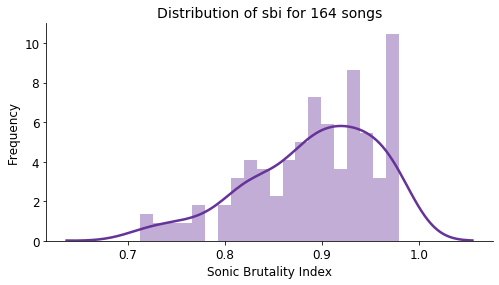

In [38]:
fig, ax = plt.subplots(figsize=(8,4))
sns.distplot(song_data['sbi'], bins=20, label="Sonic Brutaliy Index")

ax.set_title('Distribution of sbi for 164 songs', fontsize=14)
ax.set_xlabel('Sonic Brutality Index', fontsize='large')
ax.set_ylabel('Frequency', fontsize='large');

In [20]:
song_data[['title', 'sbi']].nlargest(5, 'sbi')

,title,sbi
12,High Velocity Impact Spatter,0.97995
4,Remaimed,0.97915
98,Sentenced To Burn,0.97910
81,Sanded Faceless,0.97900
157,Born In A Casket,0.97835


In [21]:
# Check for (musically) most brutal song 

most_brutal_uri = song_data['uri'].loc[song_data['sbi'] == song_data['sbi'].max()].values[0]
results = sp.track(most_brutal_uri)
print('track       : ' + results['name'])
print('from ablbum : ' + results['album']['name'])
print('audio       : ' + results['preview_url'])
print('cover art   : ' + results['album']['images'][0]['url'])

track       : High Velocity Impact Spatter
from ablbum : A Skeletal Domain
audio       : https://p.scdn.co/mp3-preview/5c8d9c416d2f43696ce70afa3dde9cb8fecf1868?cid=4a73009f43b84a8f88e6a857c198ad8f
cover art   : https://i.scdn.co/image/ab67616d0000b273898682ca3585a746e501fce3


Youtube-Clip: 

<a href="http://www.youtube.com/watch?feature=player_embedded&v=57WwWg9PD74
" target="_blank"><img src="http://img.youtube.com/vi/57WwWg9PD74/0.jpg" 
alt="Link to Youtube clip" width="240" height="180" border="10" /></a>

In [22]:
# For comparision: Lets listen to a not so brutal but danceable track now
# (don't expect too much though ...)

rabid_uri = song_data['uri'].loc[song_data['title'] == 'Rabid'].values[0]
results = sp.track(rabid_uri)
print('track       : ' + results['name'])
print('from ablbum : ' + results['album']['name'])
print('audio       : ' + results['preview_url'])
print('cover art   : ' + results['album']['images'][0]['url'])

track       : Rabid
from ablbum : Torture
audio       : https://p.scdn.co/mp3-preview/bb6155d3c987905c085cf31ed95d532f4ba16795?cid=4a73009f43b84a8f88e6a857c198ad8f
cover art   : https://i.scdn.co/image/ab67616d0000b2732d3c8436b5316b6074f407f9


Before we save the data and go on, we will first append the duration of each song to the dataframe. This is something we'll need for the calculation of the "Lyrical Brutality Index" in the next notebook.

In [23]:
def get_duration(list_of_song_uri):
    duration_dict = {}
    for song_uri in list_of_song_uri:
        results = sp.track(song_uri)
        duration_dict[song_uri] = results['duration_ms']
        
    return duration_dict

In [24]:
duration_dict = get_duration(full_tracklist.values())
song_data['duration_sec'] = song_data['uri'].apply(lambda x: duration_dict[x] / 1000)  # values are in ms
display(song_data.head(2))

retrying ...3secs


,title,uri,energy,valence,danceability,sbi,duration_sec
0,Only One Will Die,spotify:track:2VDXsHWJ9L0gFm3bL4Ic1Q,0.981,0.217,0.240,0.8820,204.320
1,Red Before Black,spotify:track:1M3QUZOIhq8LNkMJ8axsLM,0.994,0.129,0.368,0.9325,192.226


---

## Appendix: Compare Sonic Brutality of Cannibal Corpse and Cannabis Corpse

[Cannabis Corpse](https://en.wikipedia.org/wiki/Cannabis_Corpse) started out as some kind of parody of bands like Cannibal Corpse (obviously), Obituary, Death ... But meanwhile they have been around for about 13 years  and six albums. Besides of deserving credit for still finding death metal songs to make pot jokes about, I think they have developed into one of the most consistent death metal bands in general, writing really good music.(And they are a super funny live band!)

In [25]:
# Retrieve data from API

name2 = "Cannabis Corpse"

artist_uri2 = get_artist_uri(name2)
artist_albums2 = get_artist_albums(artist_uri2)
artist_albums_uri2 = get_clean_album_uri_list(artist_albums2, albums_to_delete=None)
full_tracklist2 = get_full_tracklist_dict(artist_albums_uri2)
audio_features_dict2 = get_audio_features_dict(full_tracklist2)
pprint(list(audio_features_dict2.items())[:2])
print("\nTotal Number of songs:", len(audio_features_dict2))

retrying ...6secs
[('spotify:track:3YFR8VPZDxR1euZwXOaYke',
  {'danceability': 0.227, 'energy': 0.951, 'valence': 0.184}),
 ('spotify:track:3FawebmSoA8lo0Qq4sRtlU',
  {'danceability': 0.29, 'energy': 0.926, 'valence': 0.213})]

Total Number of songs: 60


In [26]:
# Construct DataFrame
temp_df1 = pd.DataFrame(full_tracklist2.items(), columns = ['title', 'uri'])
temp_df2 = pd.DataFrame(audio_features_dict2.items(), columns = ['uri', 'features'])
assert len(temp_df1) == len(temp_df2)
song_data2 = pd.merge(temp_df1, temp_df2, on=['uri'])

song_data2['energy'] = song_data2['uri'].apply(lambda x: audio_features_dict2[x]['energy'])
song_data2['valence'] = song_data2['uri'].apply(lambda x: audio_features_dict2[x]['valence'])
song_data2['danceability'] = song_data2['uri'].apply(lambda x: audio_features_dict2[x]['danceability'])
song_data2.drop('features', axis=1, inplace=True)

In [27]:
# Calculae SBI
song_data2['sbi'] = song_data2.apply(lambda x: calc_sbi(x['valence'], x['energy']), axis=1)
display(song_data2.head(2))

,title,uri,energy,valence,danceability,sbi
0,Conquerors Of Chronageddon,spotify:track:3YFR8VPZDxR1euZwXOaYke,0.951,0.184,0.227,0.8835
1,Nug So Vile,spotify:track:3FawebmSoA8lo0Qq4sRtlU,0.926,0.213,0.290,0.8565


In [28]:
# Compare Brutality of Cannibal Corpse and Cannabis Corpse
print(f"Mean Brutality Score for {name}: {song_data['sbi'].mean():.2f}")
print(f"Mean Brutality Score for {name2}: {song_data2['sbi'].mean():.2f}")

Mean Brutality Score for Cannibal Corpse: 0.89
Mean Brutality Score for Cannabis Corpse: 0.85


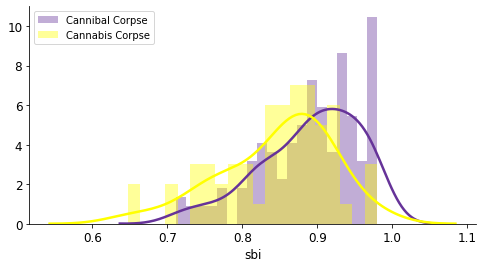

In [29]:
plt.figure(figsize=(8,4))
sns.distplot(song_data['sbi'], bins=20, label=name);
sns.distplot(song_data2['sbi'], color='yellow', bins=20, label=name2);
plt.legend(loc='upper left');

The original is just about a bit more brutal than the 'tribute band'. But not by much ... Cannabis Corpse definitely come very close.

In [30]:
# Check-out most brutal Cannabis Corpse song
most_brutal_uri2 = song_data2['uri'].loc[song_data2['sbi'] == song_data2['sbi'].max()].values[0]
results = sp.track(most_brutal_uri2)
print('track       : ' + results['name'])
print('from ablbum : ' + results['album']['name'])
print('audio       : ' + results['preview_url'])
print('cover art   : ' + results['album']['images'][0]['url'])

track       : I Cum Bud
from ablbum : Blunted at Birth
audio       : https://p.scdn.co/mp3-preview/12fb2294c21479731e01a25bf814e1ff5bc9d246?cid=4a73009f43b84a8f88e6a857c198ad8f
cover art   : https://i.scdn.co/image/ab67616d0000b273e401d75c45b023c7194242f3


In [31]:
song_data2.nlargest(1, 'sbi')

,title,uri,energy,valence,danceability,sbi
36,I Cum Bud,spotify:track:4FmDKCCpfbQoAy8svpRAYO,0.996,0.0367,0.307,0.97965


---

... one more thing, somewhat belated: Create a mapping of songtitles with respective albums and merge it into the Cannibal Corpse `song_data` DataFrame. I will use this for some extra-analysis in the appendix of the 2nd notebook only ...

In [32]:
def match_tracks_to_albums(artist_albums_uri):
    track_to_albums = []
    for album_uri in artist_albums_uri:
        album = sp.album(album_uri)
        for track in album['tracks']['items']:
            track_to_albums.append((track['name'].title(), album['name'], album['release_date']))
    return track_to_albums

In [33]:
track_to_albums = match_tracks_to_albums(artist_albums_uri)

In [34]:
temp_df = pd.DataFrame(track_to_albums, columns=['title', 'album', 'year'])
temp_df['year'] = pd.to_datetime(temp_df['year']).dt.year
# Check result
temp_df.head(2)

,title,album,year
0,Only One Will Die,Red Before Black,2017
1,Red Before Black,Red Before Black,2017


In [35]:
song_data = pd.merge(temp_df, song_data, on='title', sort='sbi')

In [36]:
## Save data
song_data.to_csv('data/interim/audio_data.csv', index=False)